<a href="https://colab.research.google.com/github/jesusvivo/amd-sm2l/blob/main/AMD_SM2L_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of flight cancellations in the US

First we will retrieve the dataset from Kaggle following the steps at [Easiest way to download kaggle data in Google Colab](https://www.kaggle.com/general/74235)

In [35]:
! pip install -q kaggle

In [36]:
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now we must upload the Kaggle API token from our machine

In [38]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"jesusvivo","key":"56a2f1ecbaabbec6b20715527201ac9d"}'}

In [39]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [40]:
! chmod 600 ~/.kaggle/kaggle.json

In [41]:
! kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04           5725        185  1.0              
kaggleashwin/population-dataset                                World Population by Countries Dataset (1960-2021)    69KB  2022-08-31 05:30:26           1615         70  1.0              
iamsouravbanerjee/house-rent-prediction-dataset                House Rent Prediction Dataset                        82KB  2022-08-20 13:49:03          11832        302  1.0              
pantanjali/unemployment-dataset                                Un

In [42]:
!kaggle datasets download -d yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018

airline-delay-and-cancellation-data-2009-2018.zip: Skipping, found more recently modified local copy (use --force to force download)


In [43]:
import zipfile
path = 'airline-delay-and-cancellation-data-2009-2018.zip'
folder = 'data'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(folder)

In [44]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[1]') \
                    .appName('FinalProject') \
                    .getOrCreate()

df = spark.read.option('header', True) \
     .csv(['data/2018.csv', 'data/2017.csv', 'data/2016.csv', 'data/2015.csv', 'data/2014.csv', \
           'data/2013.csv', 'data/2012.csv', 'data/2011.csv', 'data/2010.csv', 'data/2009.csv'])
df.printSchema()


root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- ARR_TIME: string (nullable = true)
 |-- ARR_DELAY: string (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: string (nullable = true)
 |-- CRS_ELAPSED_TIME: string (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- CARRIER_DELAY: string (nullable = true)
 |-- WEATHER_DELAY: strin

In [45]:
df.show(5)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|

Since we are only considering information prior to flight departure, we are going to keep only the columns that provide us that information

In [46]:
columns_to_keep = ['FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CANCELLED', 'CRS_ELAPSED_TIME', 'DISTANCE']

df = df.select(columns_to_keep)

df.show(10)

+----------+----------+------+----+------------+------------+---------+----------------+--------+
|   FL_DATE|OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|CRS_ELAPSED_TIME|DISTANCE|
+----------+----------+------+----+------------+------------+---------+----------------+--------+
|2018-01-01|        UA|   EWR| DEN|        1517|        1745|      0.0|           268.0|  1605.0|
|2018-01-01|        UA|   LAS| SFO|        1115|        1254|      0.0|            99.0|   414.0|
|2018-01-01|        UA|   SNA| DEN|        1335|        1649|      0.0|           134.0|   846.0|
|2018-01-01|        UA|   RSW| ORD|        1546|        1756|      0.0|           190.0|  1120.0|
|2018-01-01|        UA|   ORD| ALB|         630|         922|      0.0|           112.0|   723.0|
|2018-01-01|        UA|   ORD| OMA|        2241|          14|      0.0|            93.0|   416.0|
|2018-01-01|        UA|   IAH| LAS|         750|         916|      0.0|           206.0|  1222.0|
|2018-01-01|        

Let's see the distribution of the classes in our dataset

In [47]:
df.groupBy('CANCELLED').count().show()

+---------+--------+
|CANCELLED|   count|
+---------+--------+
|      1.0|  973209|
|      0.0|60583755|
+---------+--------+



Since we have much more items from the non cancelled class, and we have over 7 million elements, we are going to undersample the majority class in order to balance our dataset. In addition, we are going to keep the 10% of all samples to simplify the process of preparing features, model training and evaluation

In [48]:
from pyspark.sql.functions import col

def resample(dataframe, column, positive_value):
    positives = dataframe.filter(col(column) == positive_value)
    negatives = dataframe.filter(col(column) != positive_value)
    total_positives = positives.count()
    total_negatives = negatives.count()
    ratio = float(total_positives) / float(total_negatives)
    sampled = negatives.sample(False, ratio)
    return sampled.union(positives).sample(0.1)

df = resample(df, 'CANCELLED', '1.0')


In [49]:
df.groupBy('CANCELLED').count().show()

+---------+-----+
|CANCELLED|count|
+---------+-----+
|      0.0|97518|
|      1.0|97089|
+---------+-----+



Now our dataset is balanced. Now we are going to divide the flight date column into two new columns: weekday and month, in order to prepare this variable for the model

In [50]:
from pyspark.sql.functions import dayofweek, month

df = df.withColumn('FL_DATE_WEEKDAY', dayofweek('FL_DATE')).withColumn('FL_DATE_MONTH', month('FL_DATE'))
df = df.drop(df.FL_DATE)
df.show(10)

+----------+------+----+------------+------------+---------+----------------+--------+---------------+-------------+
|OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|CRS_ELAPSED_TIME|DISTANCE|FL_DATE_WEEKDAY|FL_DATE_MONTH|
+----------+------+----+------------+------------+---------+----------------+--------+---------------+-------------+
|        UA|   ORD| DEN|        1509|        1651|      0.0|           162.0|   888.0|              2|            1|
|        UA|   LAX| EWR|        1430|        2244|      0.0|           314.0|  2454.0|              2|            1|
|        UA|   DEN| EWR|        1520|        2056|      0.0|           216.0|  1605.0|              2|            1|
|        UA|   SFO| DFW|        1805|        2339|      0.0|           214.0|  1464.0|              2|            1|
|        AS|   ANC| BET|        1849|        2009|      0.0|            80.0|   399.0|              2|            1|
|        AS|   SFO| SLC|        1930|        2213|      0.0|    

Our next step will be turning the column OP_CARRIER, which is the airline of the flight, into a numerical column, called AIRLINE_ID

In [51]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = 'OP_CARRIER', outputCol = 'AIRLINE_ID') 
df = indexer.fit(df).transform(df) 
df = df.drop(df.OP_CARRIER)

df.show(10)

+------+----+------------+------------+---------+----------------+--------+---------------+-------------+----------+
|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|CRS_ELAPSED_TIME|DISTANCE|FL_DATE_WEEKDAY|FL_DATE_MONTH|AIRLINE_ID|
+------+----+------------+------------+---------+----------------+--------+---------------+-------------+----------+
|   ORD| DEN|        1509|        1651|      0.0|           162.0|   888.0|              2|            1|       6.0|
|   LAX| EWR|        1430|        2244|      0.0|           314.0|  2454.0|              2|            1|       6.0|
|   DEN| EWR|        1520|        2056|      0.0|           216.0|  1605.0|              2|            1|       6.0|
|   SFO| DFW|        1805|        2339|      0.0|           214.0|  1464.0|              2|            1|       6.0|
|   ANC| BET|        1849|        2009|      0.0|            80.0|   399.0|              2|            1|      12.0|
|   SFO| SLC|        1930|        2213|      0.0|           103.

Let's do the same now for the ORIGIN and DEST columns

In [52]:
indexer = StringIndexer(inputCol = 'ORIGIN', outputCol = 'ORIGIN_ID', stringOrderType = 'alphabetDesc') 
df = indexer.fit(df).transform(df) 
df = df.drop(df.ORIGIN)

indexer = StringIndexer(inputCol = 'DEST', outputCol = 'DEST_ID', stringOrderType = 'alphabetDesc') 
df = indexer.fit(df).transform(df) 
df = df.drop(df.DEST)

df.show(10)

+------------+------------+---------+----------------+--------+---------------+-------------+----------+---------+-------+
|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|CRS_ELAPSED_TIME|DISTANCE|FL_DATE_WEEKDAY|FL_DATE_MONTH|AIRLINE_ID|ORIGIN_ID|DEST_ID|
+------------+------------+---------+----------------+--------+---------------+-------------+----------+---------+-------+
|        1509|        1651|      0.0|           162.0|   888.0|              2|            1|       6.0|    108.0|  274.0|
|        1430|        2244|      0.0|           314.0|  2454.0|              2|            1|       6.0|    169.0|  253.0|
|        1520|        2056|      0.0|           216.0|  1605.0|              2|            1|       6.0|    270.0|  253.0|
|        1805|        2339|      0.0|           214.0|  1464.0|              2|            1|       6.0|     50.0|  273.0|
|        1849|        2009|      0.0|            80.0|   399.0|              2|            1|      12.0|    346.0|  338.0|
|        1930|  

Finally, we are going to drop the CRS_ARR_TIME and DISTANCE columns, since they have a strong correlation with the CRS_DEP_TIME and CRS_ELAPSED_TIME columns, respectively. We are going to keep the latter ones because their values are lower and have less variance.

In [53]:
df = df.drop('CRS_ARR_TIME', 'DISTANCE')
df.show(10)

+------------+---------+----------------+---------------+-------------+----------+---------+-------+
|CRS_DEP_TIME|CANCELLED|CRS_ELAPSED_TIME|FL_DATE_WEEKDAY|FL_DATE_MONTH|AIRLINE_ID|ORIGIN_ID|DEST_ID|
+------------+---------+----------------+---------------+-------------+----------+---------+-------+
|        1509|      0.0|           162.0|              2|            1|       6.0|    108.0|  274.0|
|        1430|      0.0|           314.0|              2|            1|       6.0|    169.0|  253.0|
|        1520|      0.0|           216.0|              2|            1|       6.0|    270.0|  253.0|
|        1805|      0.0|           214.0|              2|            1|       6.0|     50.0|  273.0|
|        1849|      0.0|            80.0|              2|            1|      12.0|    346.0|  338.0|
|        1930|      0.0|           103.0|              2|            1|      12.0|     50.0|   43.0|
|         805|      0.0|           345.0|              2|            1|      12.0|     44.0

As last steps of cleaning and preparing the datasets, we will select the final list of features for our model in order to normalize them and remove any that has some missing value

In [54]:
cols_to_normalize = ['CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'FL_DATE_WEEKDAY','FL_DATE_MONTH','AIRLINE_ID', 'ORIGIN_ID','DEST_ID']

df = df.dropna(how = 'any')

In [55]:
df.printSchema()

root
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- CRS_ELAPSED_TIME: string (nullable = true)
 |-- FL_DATE_WEEKDAY: integer (nullable = true)
 |-- FL_DATE_MONTH: integer (nullable = true)
 |-- AIRLINE_ID: double (nullable = false)
 |-- ORIGIN_ID: double (nullable = false)
 |-- DEST_ID: double (nullable = false)



We are going to transform the columns that are strings into integers in order to build the vector of features correctly

In [56]:
df = df.withColumn('CRS_DEP_TIME', df.CRS_DEP_TIME.cast('int')) \
        .withColumn('CANCELLED', df.CANCELLED.cast('int')) \
        .withColumn('CRS_ELAPSED_TIME', df.CRS_ELAPSED_TIME.cast('int'))

In [57]:
df.printSchema()

root
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 |-- CRS_ELAPSED_TIME: integer (nullable = true)
 |-- FL_DATE_WEEKDAY: integer (nullable = true)
 |-- FL_DATE_MONTH: integer (nullable = true)
 |-- AIRLINE_ID: double (nullable = false)
 |-- ORIGIN_ID: double (nullable = false)
 |-- DEST_ID: double (nullable = false)



Adding a new column with the vectorized features

In [58]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler().setInputCols(cols_to_normalize).setOutputCol('vectorized_features')
df = assembler.transform(df)
df.show(10)

+------------+---------+----------------+---------------+-------------+----------+---------+-------+--------------------+
|CRS_DEP_TIME|CANCELLED|CRS_ELAPSED_TIME|FL_DATE_WEEKDAY|FL_DATE_MONTH|AIRLINE_ID|ORIGIN_ID|DEST_ID| vectorized_features|
+------------+---------+----------------+---------------+-------------+----------+---------+-------+--------------------+
|        1509|        0|             162|              2|            1|       6.0|    108.0|  274.0|[1509.0,162.0,2.0...|
|        1430|        0|             314|              2|            1|       6.0|    169.0|  253.0|[1430.0,314.0,2.0...|
|        1520|        0|             216|              2|            1|       6.0|    270.0|  253.0|[1520.0,216.0,2.0...|
|        1805|        0|             214|              2|            1|       6.0|     50.0|  273.0|[1805.0,214.0,2.0...|
|        1849|        0|              80|              2|            1|      12.0|    346.0|  338.0|[1849.0,80.0,2.0,...|
|        1930|        0|

Normalizing the features vector and getting the final vector that will be the input for our model

In [59]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler().setInputCol('vectorized_features').setOutputCol('features')
df = scaler.fit(df).transform(df)
df.show(10)

+------------+---------+----------------+---------------+-------------+----------+---------+-------+--------------------+--------------------+
|CRS_DEP_TIME|CANCELLED|CRS_ELAPSED_TIME|FL_DATE_WEEKDAY|FL_DATE_MONTH|AIRLINE_ID|ORIGIN_ID|DEST_ID| vectorized_features|            features|
+------------+---------+----------------+---------------+-------------+----------+---------+-------+--------------------+--------------------+
|        1509|        0|             162|              2|            1|       6.0|    108.0|  274.0|[1509.0,162.0,2.0...|[3.15010565987191...|
|        1430|        0|             314|              2|            1|       6.0|    169.0|  253.0|[1430.0,314.0,2.0...|[2.98518959152871...|
|        1520|        0|             216|              2|            1|       6.0|    270.0|  253.0|[1520.0,216.0,2.0...|[3.17306865672982...|
|        1805|        0|             214|              2|            1|       6.0|     50.0|  273.0|[1805.0,214.0,2.0...|[3.76801902986666...|

Our dataset is ready to be trained. Let's split it and build our model with it. We will convert our PySpark Dataframes to NumPy arrays, in order to perform the mathematical operations with them

In [60]:
train, test = df.randomSplit([0.8, 0.2])

In [61]:
import numpy as np

X_train = np.array(train.select('features').collect())
X_train = np.reshape(X_train, (len(X_train), len(X_train[0][0])))

X_test = np.array(test.select('features').collect())
X_test = np.reshape(X_test, (len(X_test), len(X_test[0][0])))

y_train = np.array(train.select('CANCELLED').collect())
y_train = np.reshape(y_train, (len(y_train),))

y_test = np.array(test.select('CANCELLED').collect())
y_test = np.reshape(y_test, (len(y_test),))

In [62]:
class LogisticRegression:
    def __init__(self, learning_rate = 0.01, n_iterations = 1000, lambda_value = 1):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.lambda_value = lambda_value
        self.weights = None
        self.bias = None
        

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):        
        M, N = X.shape

        # First we initialize the weights vector, which has a size equal to 
        # the number of features, with zeros
        # We also set the initial bias parameter to 0

        self.weights = np.zeros(N)
        self.bias = 0

        # We initiate now the learning loop

        for i in range(self.n_iterations):
            # Calculate the prediction applying the y = w · x + b linear function.
            # Then apply the sigmoid function to the linear prediction
            # so that it returns a value between 0 and 1.

            Z = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(Z)

            # Calculate regularization term (L2) to apply it on the cost function
            regularization_term = self.lambda_value * np.sum(np.square(self.weights))

            # We now compute the cost using the log loss function, 
            # in order to test different hyperparameter settings
            cost = - (1 / M) * np.sum(y * np.log(y_predicted) + (1 - y) *  np.log(1 - y_predicted)) + regularization_term

            # Apply gradient descent to optimize weights and bias and update them
            dW = (1 / M) * np.dot(X.T, (y_predicted - y))
            dB = (1 / M) * np.sum(y_predicted - y)

            self.weights = self.weights - self.learning_rate * dW
            self.bias = self.bias - self.learning_rate * dB

    def predict(self, X):
        Z = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(Z)

        y_predicted = [1 if i > 0.5 else 0 for i in y_predicted]

        return np.array(y_predicted)
    
    def F1_score(self, y_test, y_predictions):
      true_positives, true_negatives, false_positives, false_negatives = 0, 0, 0, 0

      for i in range(len(y_test)):
          if y_test[i] == 1 and y_predictions[i] == 1:
              true_positives += 1
          elif y_test[i] == 0 and y_predictions[i] == 1:
              false_positives += 1
          elif y_test[i] == 0 and y_predictions[i] == 0:
              true_negatives += 1
          elif y_test[i] == 1 and y_predictions[i] == 0:
              false_negatives += 1

      precision = true_positives / (true_positives + false_positives)
      recall = true_positives / (true_positives + false_negatives)
      F1_score = 2 * precision * recall / (precision + recall)
      return F1_score

In [63]:
model = LogisticRegression(learning_rate = 0.2, n_iterations = 1000, lambda_value = 1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

Let's see the metrics for our model:

In [64]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.58      0.55      0.57     19533
           1       0.57      0.59      0.58     19543

    accuracy                           0.57     39076
   macro avg       0.57      0.57      0.57     39076
weighted avg       0.57      0.57      0.57     39076



If we take a look at the average values, we can see that they are decent. They can be probably improved by tuning this model or testing new strategies on the features. We will do the tuning later.

In addition, we can see that the difference in F1 scores is slightly different between classes, although it is really similar. This is a great improvement, since at first, working with the original imbalanced dataset, F1 score for the cancelled class was close to 0.

Let's now check the AUC metric for our model:

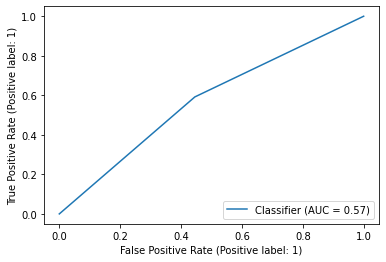

In [65]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, predictions)

Let's tune our model by using grid search, combining different hyperparameter values:

In [67]:
  from sklearn.metrics import f1_score

  best_F1_score = 0
  best_n_iterations = 0
  best_learning_rate = 0
  best_lambda_value = 1
    
  # Different values for the combination of hyperparameters
  learning_rates = [0.1, 0.2, 0.4, 
                    0.01, 0.02, 0.04]
 
  n_iterations = [100, 200, 400, 500, 1000]

  lambda_values = [0.001, 0.01, 0.1, 1, 10, 100]
    
  # Let's build the different combinations
    
  parameter_combinations = []    
  for i in learning_rates:        
      for j in n_iterations:          
        parameter_combinations.append((i, j))
 
  for k in range(len(parameter_combinations)):        
      model = LogisticRegression(
          learning_rate = parameter_combinations[k][0], 
          n_iterations = parameter_combinations[k][1])
    
      model.fit(X_train, y_train)
      
      y_pred = model.predict(X_test)

      curr_F1_score = f1_score(y_test, y_pred, average = 'macro')

      print("Combination: ", parameter_combinations[k], ", F1 score: ", curr_F1_score)

      if best_F1_score < curr_F1_score:            
          best_F1_score = curr_F1_score
          best_learning_rate = parameter_combinations[k][0]
          best_n_iterations = parameter_combinations[k][1]

Combination:  (0.1, 100) , F1 score:  0.5721155528133258
Combination:  (0.1, 200) , F1 score:  0.5724701210419376
Combination:  (0.1, 400) , F1 score:  0.5725024347153809
Combination:  (0.1, 500) , F1 score:  0.5728037802649923
Combination:  (0.1, 1000) , F1 score:  0.5736074043182883
Combination:  (0.2, 100) , F1 score:  0.5724956449641978
Combination:  (0.2, 200) , F1 score:  0.5725024347153809
Combination:  (0.2, 400) , F1 score:  0.5740559997510816
Combination:  (0.2, 500) , F1 score:  0.5736074043182883
Combination:  (0.2, 1000) , F1 score:  0.5730920792011125
Combination:  (0.4, 100) , F1 score:  0.3509106906738535
Combination:  (0.4, 200) , F1 score:  0.3513603240210481
Combination:  (0.4, 400) , F1 score:  0.3514046745764834
Combination:  (0.4, 500) , F1 score:  0.35079072743319945
Combination:  (0.4, 1000) , F1 score:  0.35147171285301293
Combination:  (0.01, 100) , F1 score:  0.5667232866628926
Combination:  (0.01, 200) , F1 score:  0.5702858293477744
Combination:  (0.01, 400

Now let's tune our regularization parameter (lambda value)

In [68]:
  for k in range(len(lambda_values)):
      model = LogisticRegression(
        learning_rate = best_learning_rate, 
        n_iterations = best_n_iterations,
        lambda_value = k)
      
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      curr_F1_score = model.F1_score(y_test, y_pred)

      if best_F1_score < curr_F1_score:            
          best_F1_score = curr_F1_score
          best_lambda_value = lambda_values[k]


In [69]:
print("Best combination of hyperparameters: ")
print("LR: ", best_learning_rate, " N. Iters: ", best_n_iterations, " Lambda: ", best_lambda_value)

Best combination of hyperparameters: 
LR:  0.2  N. Iters:  400  Lambda:  0.001


              precision    recall  f1-score   support

           0       0.58      0.56      0.57     19533
           1       0.57      0.59      0.58     19543

    accuracy                           0.57     39076
   macro avg       0.57      0.57      0.57     39076
weighted avg       0.57      0.57      0.57     39076



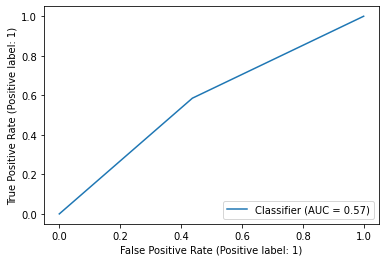

In [70]:
best_model = LogisticRegression(
    learning_rate = best_learning_rate,
    n_iterations = best_n_iterations,
    lambda_value = best_lambda_value)

best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)

print(classification_report(y_test, predictions))
RocCurveDisplay.from_predictions(y_test, predictions)

Our model isn't great, but now let's compare our model with the Logistic Regression implementation in the MLlib library from PySpark: 

In [71]:
from pyspark.ml.classification import LogisticRegression

model2 = LogisticRegression(featuresCol = 'features', labelCol = 'CANCELLED', maxIter = 1000)
model2 = model2.fit(train)

In [72]:
predictions_model2 = model2.transform(test)

In [73]:
y_true2 = predictions_model2.select("CANCELLED")
y_true2 = y_true2.toPandas()

y_pred2 = predictions_model2.select("prediction")
y_pred2 = y_pred2.toPandas()

In [74]:
print(classification_report(y_true2, y_pred2))

              precision    recall  f1-score   support

           0       0.58      0.55      0.56     19533
           1       0.57      0.60      0.58     19543

    accuracy                           0.57     39076
   macro avg       0.57      0.57      0.57     39076
weighted avg       0.57      0.57      0.57     39076



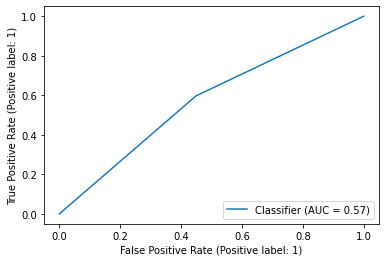

In [75]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true2, np.array(predictions_model2.select('prediction').collect()))

Comparing both models, the metrics are almost identical. We can say that our implementation is fine.